# Noise Series Viewer

This notebook walks through the data acquired in a single noise acquisition with the USRP. It shows the VNA data and fit result, the noise timestreams, and the PSD of the noise.

In [1]:
import sys, os, glob, h5py
import time, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf

import ResonanceFitter as resfit

In [2]:
series = "20231017_124637"

PSD_min_f_Hz = 1.0e2
PSD_max_f_Hz = 5.0e4

### Parse the Metadata

In [3]:
sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)

Line Delay file:  USRP_Delay_20231017_124637.h5
VNA scan file:    USRP_VNA_20231017_124637.h5
Noise ts files:   ['USRP_Noise_20231017_124637_delta0.h5']
Laser ts files:   []
Summary file:	 noise_averages_20231017_124637.h5


In [4]:
print("Calibration Deltas")
for f, z in zip(avg_frqs, avg_S21s):
    print("F-tone:",("%5.4f MHz" % f),"--","Avg S21:",z)

Calibration Deltas
F-tone: 5387.3990 MHz -- Avg S21: (0.005239086316675227-0.0015228334423326166j)
F-tone: 5387.4031 MHz -- Avg S21: (0.005177620574403544-0.001579399665719302j)
F-tone: 5387.4073 MHz -- Avg S21: (0.0051635550857604155-0.0015468436327137607j)


## VNA Scan and Fit

In [5]:
vna_f, vna_z = PUf.read_vna(vna_file) ### vna_f in MHz

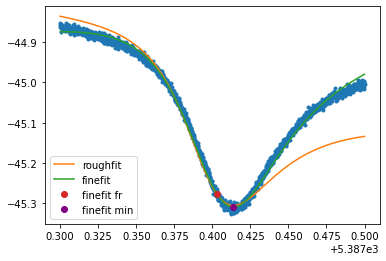

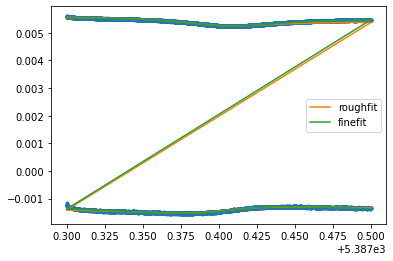

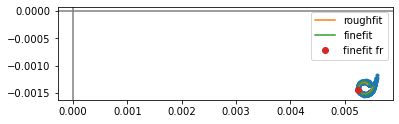

In [6]:
res_pars, res_errs = resfit.finefit(vna_f, vna_z, [avg_frqs[1]], 
                                    restrict_fit_MHz=None, plot=True, verbose=False)

In [7]:
for k in res_pars.keys():
    print(k,":",res_pars[k],"+/-",res_errs[k])

f0 : 5387.403148055219 +/- 0.0002582244353548573
Qr : 65524.404100369225 +/- 411.5692009674896
phi : 0.524843633906138 +/- 0.00874148976588744
zOff : (0.005546558626698856-0.001361527609178019j) +/- (1.1065260136700644e-06+1.3205979512188356e-06j)
QcHat : 1212457.882928631 +/- 10598.693891227085
tau : (0.025604447865617205+0.0062353253564617584j) +/- (0.000319826831038863+0.0003200418141966325j)
Qc : 1401033.8054979478 +/- 10599.098846527822


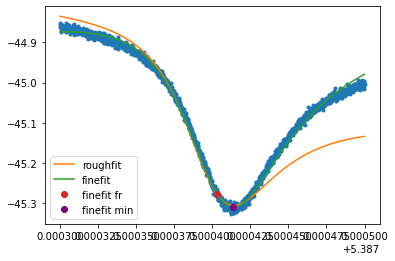

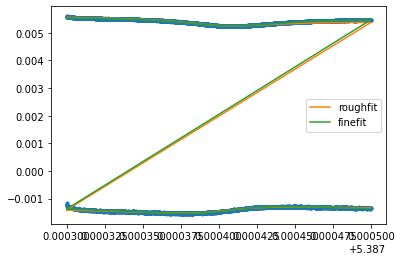

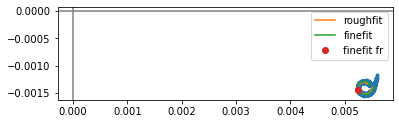

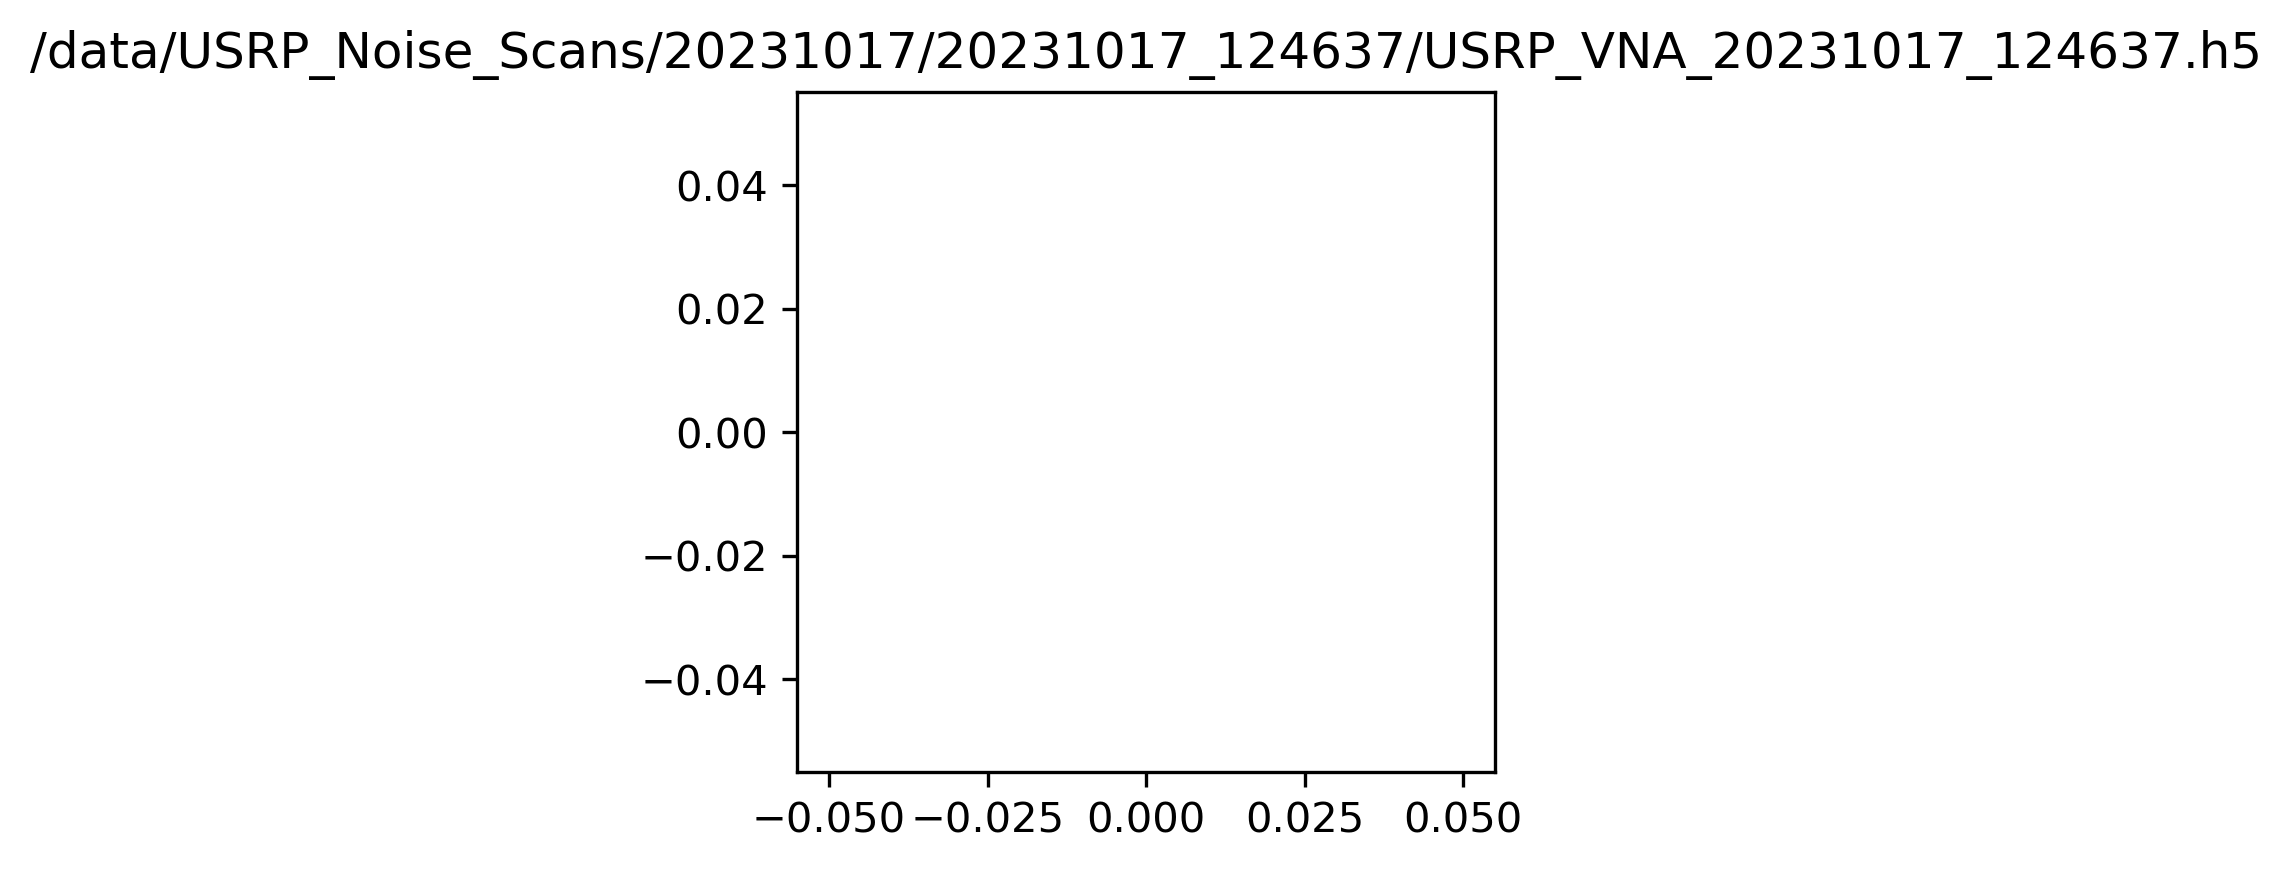

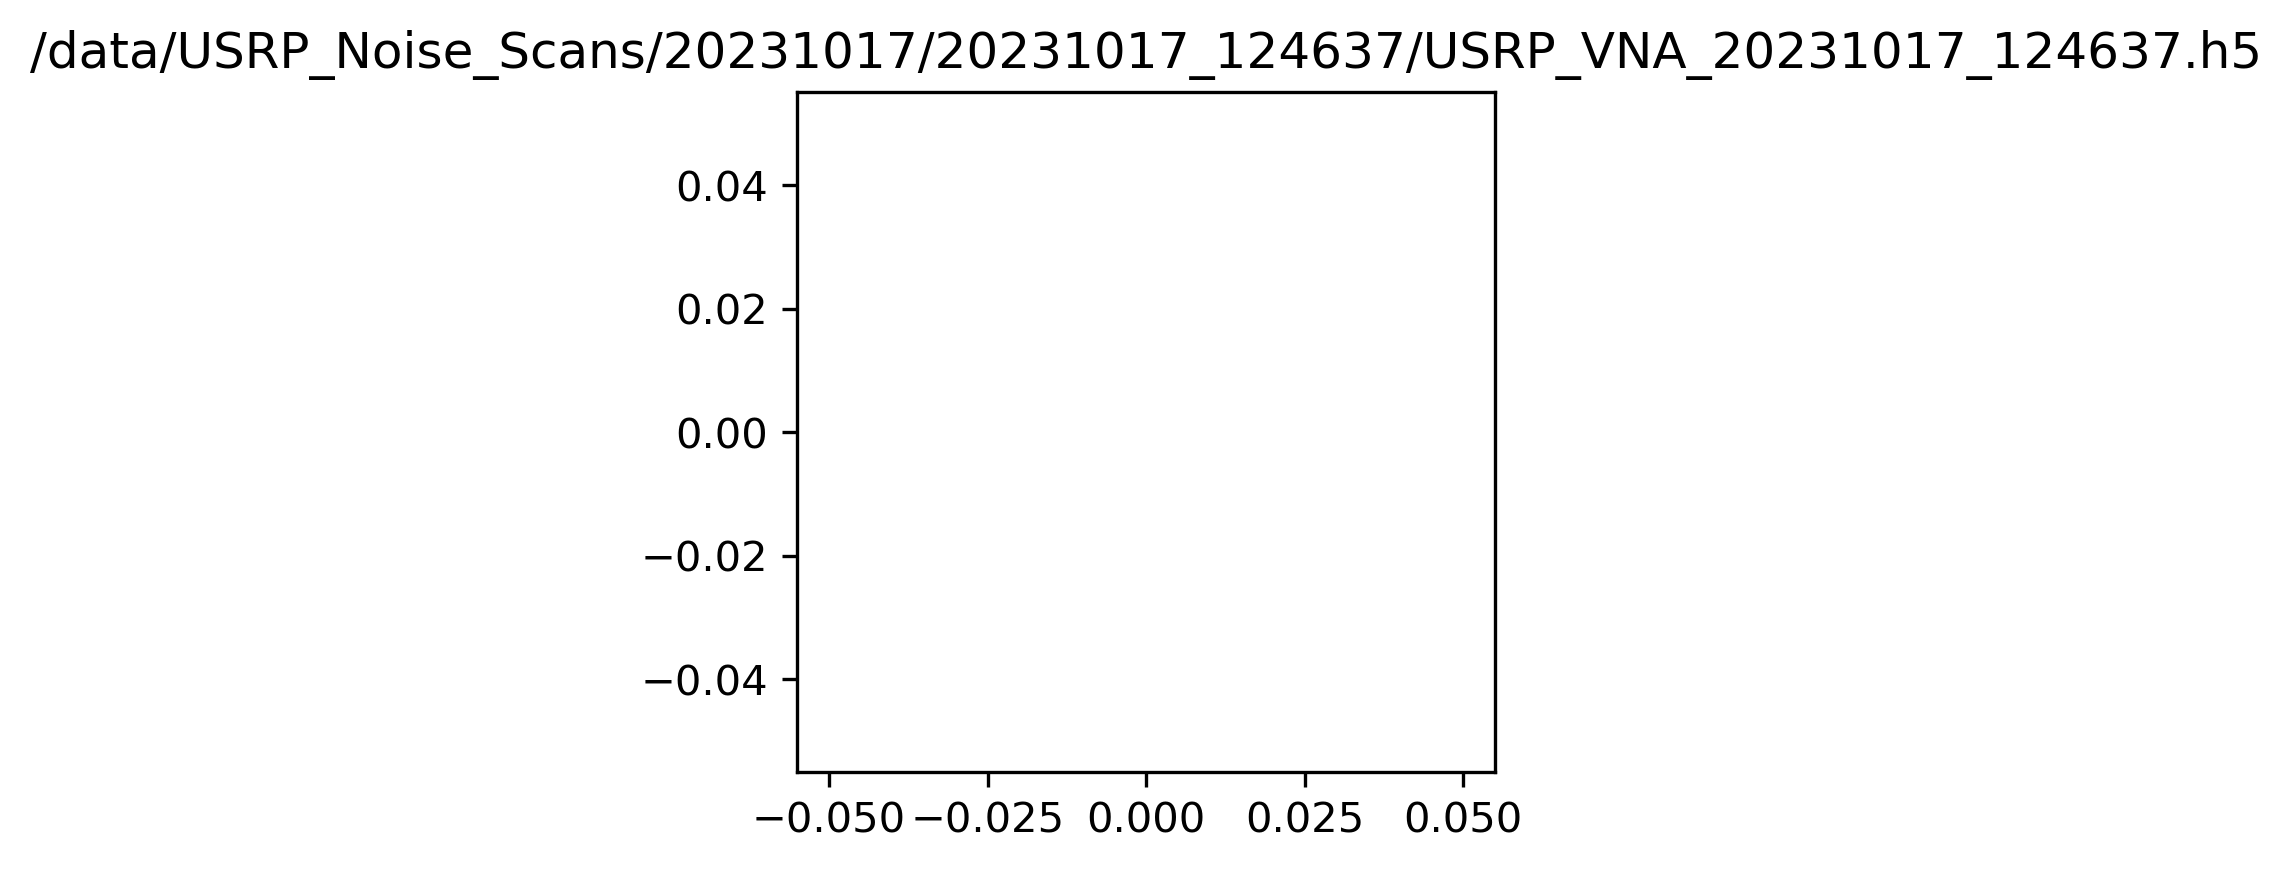

In [8]:
PUf.plot_VNA(vna_file, [avg_frqs[1]*1e-3]) ## Have to pass resonance in GHz

## Noise Timestreams & PSD

Will separate data into  3000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation by factor of 20
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20231017/20231017_124637/USRP_Noise_20231017_124637_delta0.h5 because override=True!
found 11 pulses
chunk length plugged into welch is 500
chunked data into 3000 timestreams
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20231017/20231017_124637/USRP_Noise_20231017_124637_delta0_cleaned.h5 because override=True!
number of chunks used to average is 2765
Converting to resonator basis!
Fr from fit  [GHz]: 5387.403148055219
Fr min curve [GHz]: 5387.413856928463
Fr from fit  [GHz]: 5387.403148055219
Fr min curve [GHz]: 53

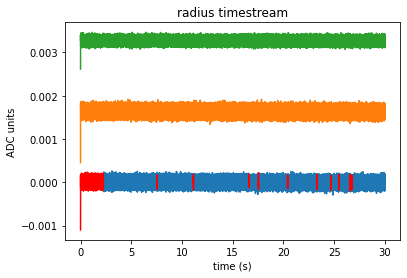

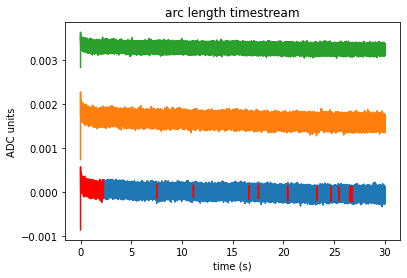

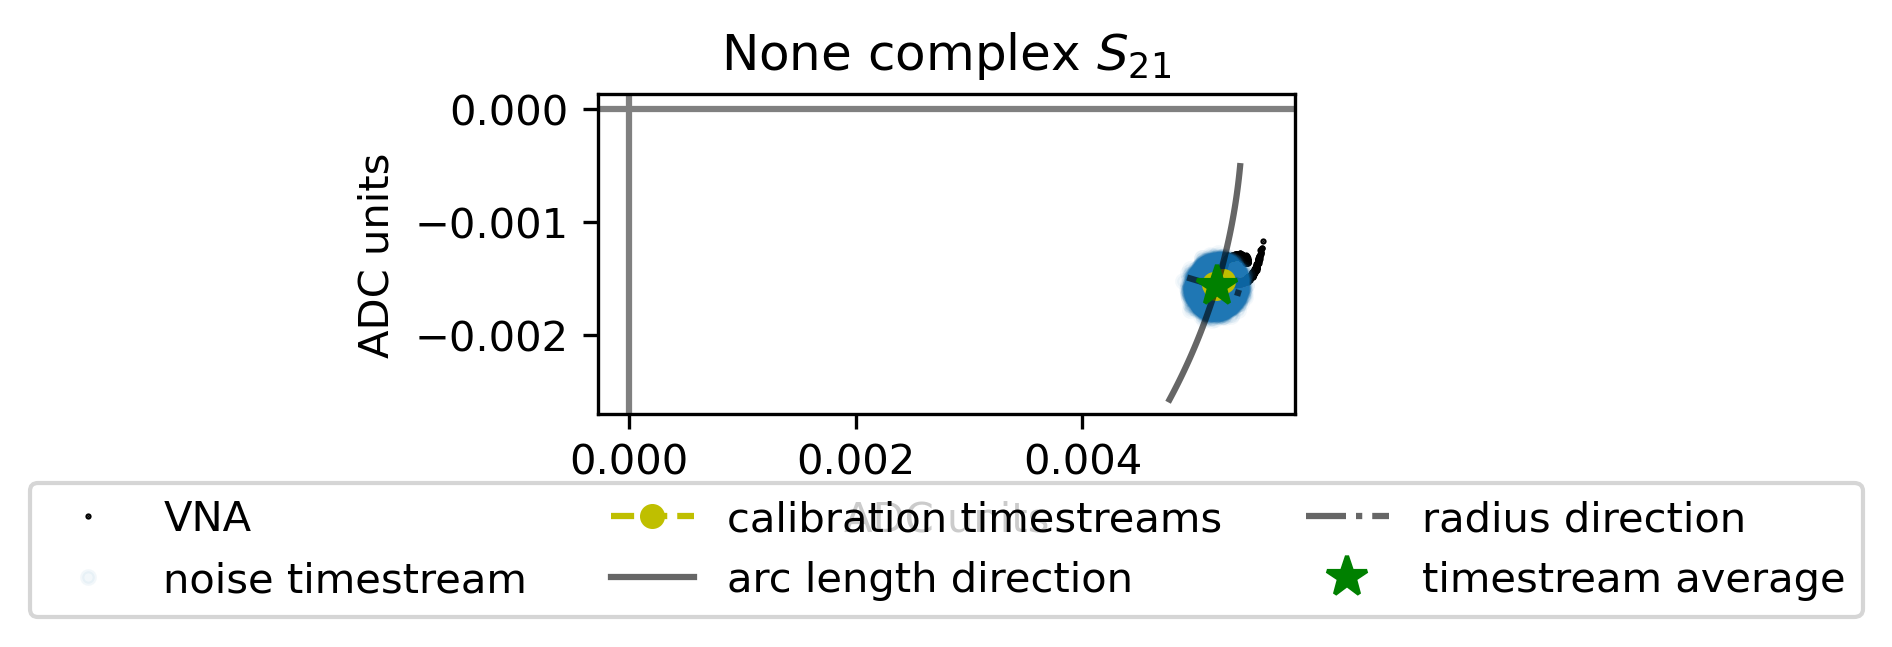

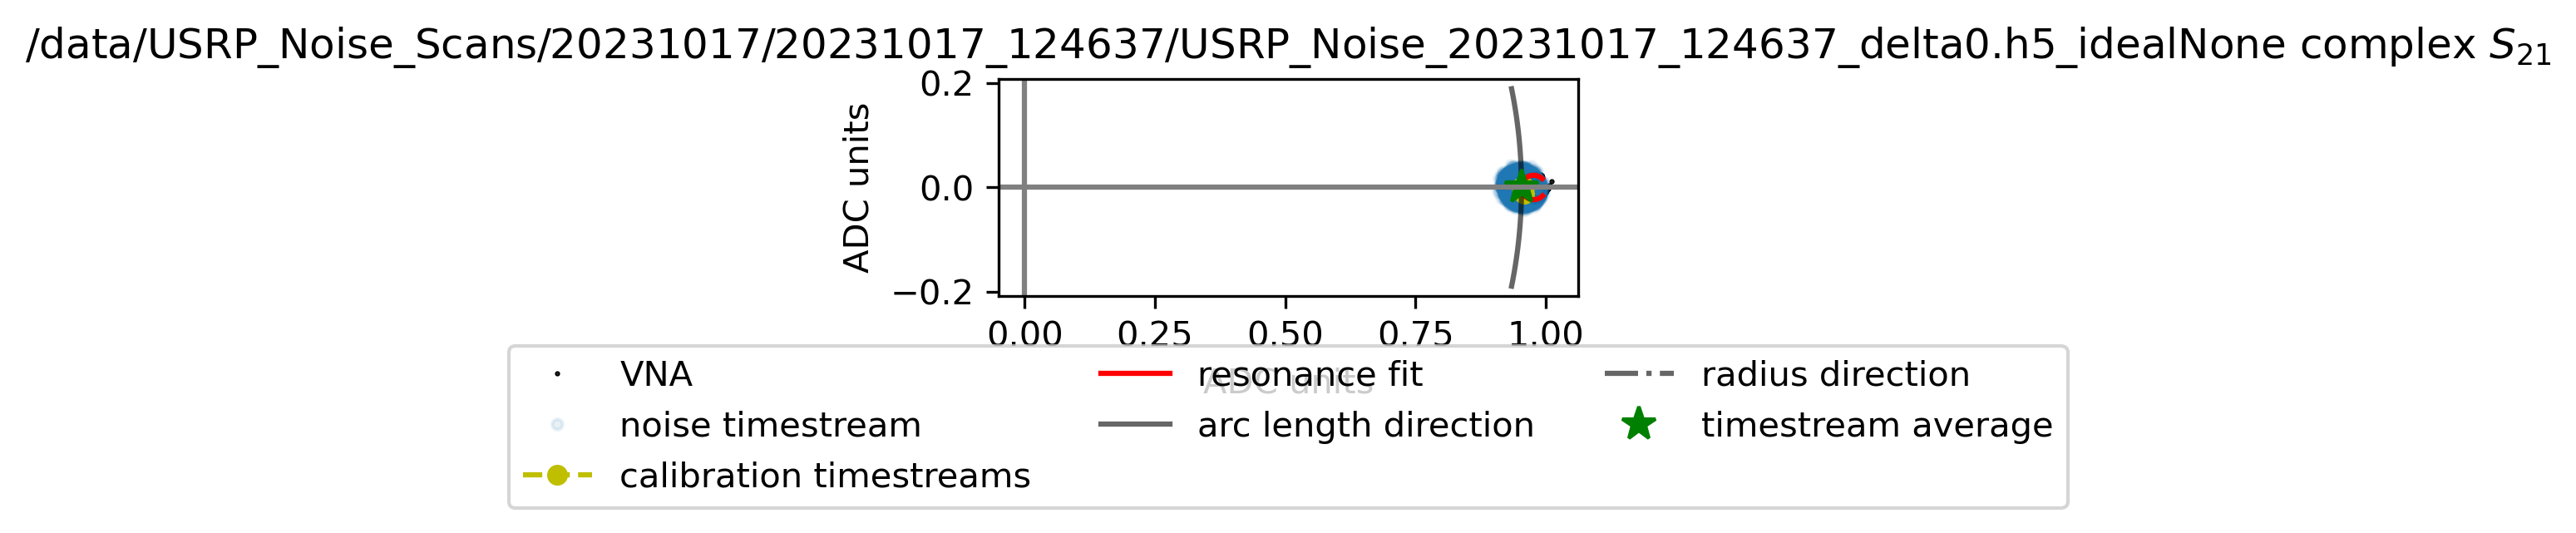

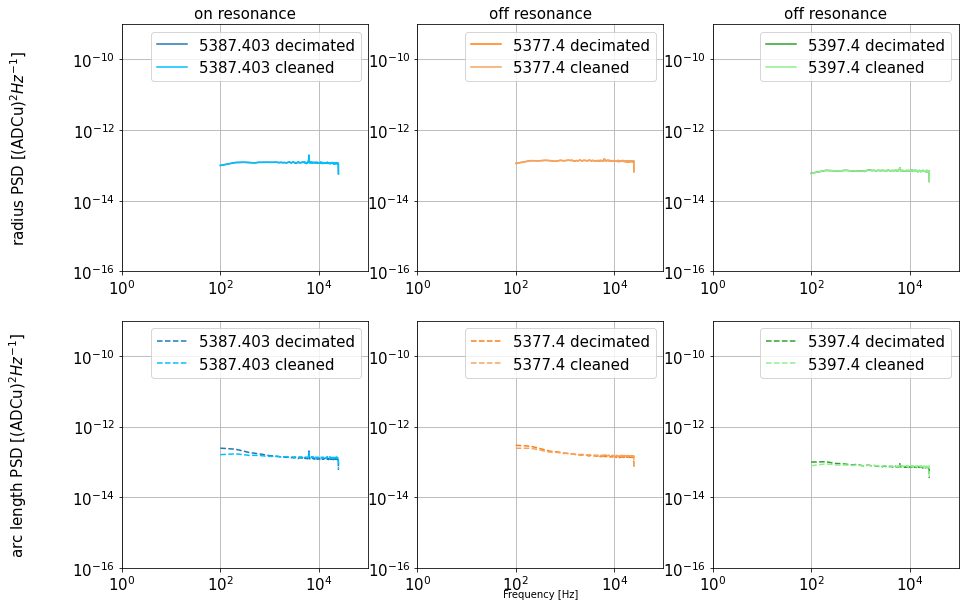

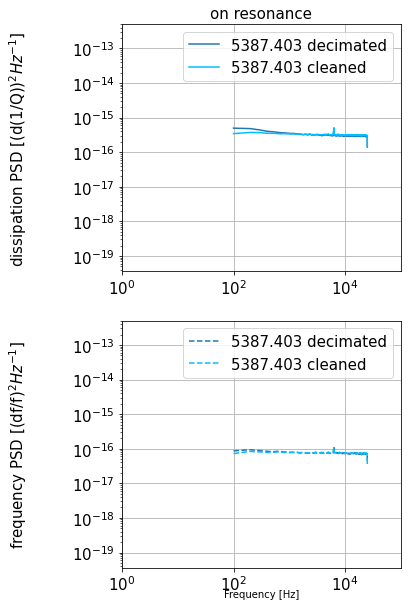

In [9]:
powers, PSDs, res, timestreams = Thf.CleanPSDs(tone_files[0], vna_file, f_transient=0.075,
                                               charFs     = avg_frqs,
                                               charZs     = avg_S21s,
                                               PSD_lo_f   = PSD_min_f_Hz, 
                                               PSD_hi_f   = PSD_max_f_Hz,
                                               MBresults  = None,
                                               show_plots = True,
                                               verbose    = True)